In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

e:\chatbot_emotion\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set(style="whitegrid")

In [4]:
# 2. Load Model and Tokenizer
MODEL_DIR = "../data/models/meld_emotion_model"  # Change according to your path
TEST_CSV = "../data/datasets/MELD/formatted_test_sent_emo.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(device)
model.eval()

W0730 11:49:35.693000 3172 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [5]:
# 3. Load and preprocess test dataset
test_df = pd.read_csv(TEST_CSV)
test_df = test_df.dropna(subset=['Utterance', 'Emotion', 'label'])

In [6]:
# 4. Tokenize test utterances
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), truncation=True, padding=True, return_tensors="pt")

batch_size = 32
all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(0, len(test_df), batch_size):
        batch_texts = test_df['Utterance'].iloc[i:i+batch_size].tolist()
        batch_labels = test_df['label'].iloc[i:i+batch_size].tolist()

        encoded = tokenizer(batch_texts, truncation=True, padding=True, return_tensors="pt")
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().tolist()

        all_preds.extend(preds)
        all_labels.extend(batch_labels)

In [7]:
# 5. Map labels to emotion strings
id2label = {int(k): v for k, v in model.config.id2label.items()}
pred_emotions = [id2label[p] for p in all_preds]
true_emotions = [id2label[t] for t in all_labels]

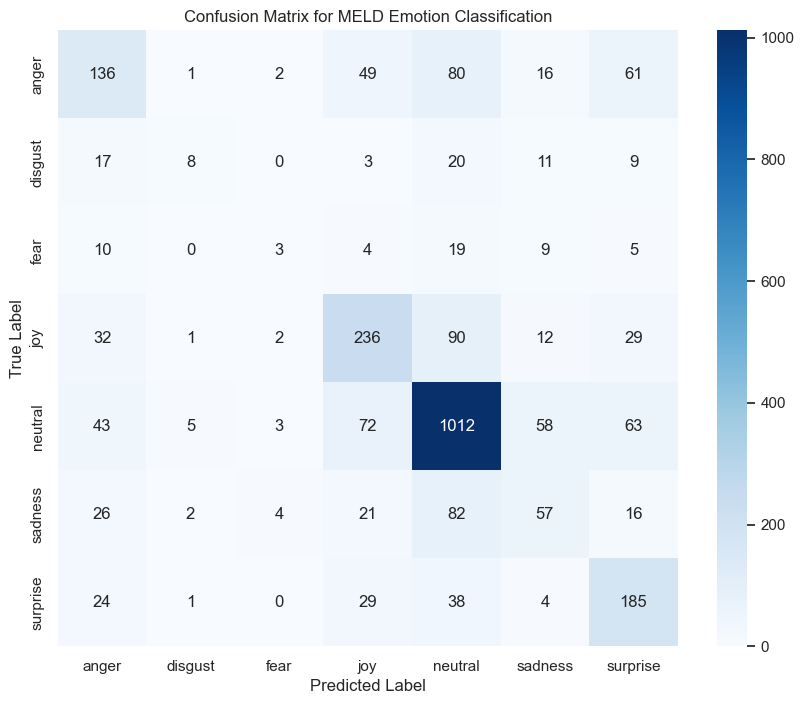

In [9]:
# 6. Confusion Matrix
cm = confusion_matrix(true_emotions, pred_emotions, labels=list(id2label.values()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=id2label.values(), yticklabels=id2label.values(), cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for MELD Emotion Classification")
plt.show()

In [10]:
# 7. Classification Report
print("Classification Report:\n")
print(classification_report(true_emotions, pred_emotions, digits=4))

Classification Report:

              precision    recall  f1-score   support

       anger     0.4722    0.3942    0.4297       345
     disgust     0.4444    0.1176    0.1860        68
        fear     0.2143    0.0600    0.0938        50
         joy     0.5700    0.5871    0.5784       402
     neutral     0.7547    0.8057    0.7794      1256
     sadness     0.3413    0.2740    0.3040       208
    surprise     0.5027    0.6584    0.5701       281

    accuracy                         0.6272      2610
   macro avg     0.4714    0.4139    0.4202      2610
weighted avg     0.6104    0.6272    0.6132      2610



In [11]:
# 8. Analyze Most Confused Pairs
def get_most_confused(cm, labels, top_n=5):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)  # Zero out diagonal
    flat = cm_no_diag.flatten()
    top_indices = flat.argsort()[-top_n:][::-1]

    confusion_pairs = []
    for idx in top_indices:
        i = idx // cm_no_diag.shape[0]
        j = idx % cm_no_diag.shape[0]
        confusion_pairs.append((labels[i], labels[j], cm_no_diag[i, j]))
    return confusion_pairs

confused_pairs = get_most_confused(cm, list(id2label.values()))
print("Top Confused Emotion Label Pairs:")
for true_label, pred_label, count in confused_pairs:
    print(f"True '{true_label}' predicted as '{pred_label}' {count} times")

Top Confused Emotion Label Pairs:
True 'joy' predicted as 'neutral' 90 times
True 'sadness' predicted as 'neutral' 82 times
True 'anger' predicted as 'neutral' 80 times
True 'neutral' predicted as 'joy' 72 times
True 'neutral' predicted as 'surprise' 63 times


In [12]:
# 9. Show example misclassified utterances
print("\nSample Misclassified Examples:\n")
misclassified = test_df[(test_df['label'] != pd.Series(all_preds))]

for _, row in misclassified.sample(min(5, len(misclassified))).iterrows():
    print(f"Utterance: {row['Utterance']}")
    print(f"True Emotion: {id2label[row['label']]}")
    print(f"Predicted Emotion: {id2label[all_preds[_]]}")
    print("---")


Sample Misclassified Examples:

Utterance: Umm, well I would have to say that it's a, it's tragic love story.
True Emotion: neutral
Predicted Emotion: sadness
---
Utterance: Oh Chandler, I know, I know... oh, hey! You can see your nipples through this shirt!
True Emotion: sadness
Predicted Emotion: joy
---
Utterance: Who, Josh?
True Emotion: surprise
Predicted Emotion: neutral
---
Utterance: Whoa, I'm sorry. Excuse me. We had this cart.
True Emotion: anger
Predicted Emotion: surprise
---
Utterance: Yes. Absolutely. A quality.
True Emotion: neutral
Predicted Emotion: joy
---
